# importing libraries



In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import random
import os
import cv2
import matplotlib.pyplot as plt
import math

# Connect to gpus

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024*8.25)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

In [ ]:
def fix_seeds(seed: int) -> None:
  """ Fix random seeds for numpy, tensorflow, random, etc.

  Parameters
  -----------
  seed : int.
  Random seed.
  """

  np.random.seed(seed) # numpy seed
  tf.random.set_seed(seed) # tensorflow seed
  random.seed(seed) # random seed
  os.environ['TF_DETERMINISTIC_OPS'] = "1"
  os.environ['TF_CUDNN_DETERMINISM'] = "1"
  os.environ['PYTHONHASHSEED'] = str(seed)

fix_seeds(40)

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1916648455672654680
xla_global_id: -1
]


In [6]:
tf.test.is_built_with_cuda()

True

In [7]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# preprocesing

In [13]:
image_cover = cv2.imread(r"C:\Users\Home\Downloads\UNIWARD_datasets\dataset_pgm_UNIWARD_04\train\0\3.pgm", cv2.IMREAD_UNCHANGED)
image_stego = cv2.imread(r"C:\Users\Home\Downloads\UNIWARD_datasets\dataset_pgm_UNIWARD_04\train\1\3.pgm", cv2.IMREAD_UNCHANGED)


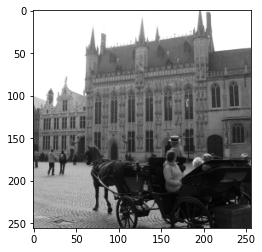

In [14]:
plt.imshow(image_cover,cmap='gray', vmin=0, vmax=255)

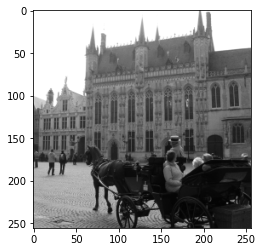

In [15]:
plt.imshow(image_stego,cmap='gray', vmin=0, vmax=255)

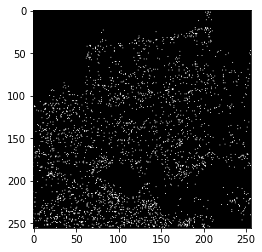

In [16]:
plt.imshow(image_cover-image_stego,cmap='gray', vmin=0, vmax=255)

In [76]:
image_cover.shape

(512, 512)

In [77]:
import numpy as np
import random
import os
import cv2
import tensorflow as tf
import math

class PairedImageGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dim=(256, 256), n_channels=1, batch_size=16, images_path_cover='/', images_path_stego='/', shuffle=True, augment=True, seed=None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.images_path_stego = images_path_stego
        self.images_path_cover = images_path_cover
        self.shuffle = shuffle
        self.augment = augment

        # Set the seed
        if seed != None:
            np.random.seed(seed)
            tf.random.set_seed(seed)
        
        # cover and stego filenames should be the same
        self.image_names = os.listdir(self.images_path_cover)
        self.indices = np.arange(len(self.image_names))

        # Shuffle the indices
        self.shuffle_indices()


    def __getitem__(self, i):
        # Select the indices that should be used now
        inds = self.indices[i * (self.batch_size//2):(i + 1) * (self.batch_size//2)]

        # Select the filenames
        batch_filenames = [self.image_names[i] for i in inds]

        # Get the X and the y
        X, y = self.__data_generation(batch_filenames)

        return X, y
    

    def __len__(self):
        return math.ceil(len(self.image_names) / (self.batch_size//2))


    def on_epoch_end(self):
        self.shuffle_indices()


    def preprocessing(self, image):
        image = image
        return image


    def data_augmentation(self, cover, stego):
        rotation = np.random.choice([-1, 0, 1])
        # Rotate the image 90, -90 or 0 degrees.
        cover = np.rot90(cover, rotation)
        stego = np.rot90(stego, rotation)
        
        # With 50% probability, the image is flipped horizontally.
        if tf.random.uniform(()) > 0.5:
            cover = tf.image.flip_left_right(cover)
            stego = tf.image.flip_left_right(stego)
    
        return cover, stego
    

    def __data_generation(self, batch_filenames):
        'Generates data of batch_size samples' # X : (n_samples, v_size, v_size, v_size, n_channels)

        # Initialization

        X = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels))
        y = np.empty((self.batch_size), dtype = int)

        # Generate data

        for i, filename in enumerate(batch_filenames):

            # Read both the cover and the stego images
            im_cover = cv2.imread(os.path.join(self.images_path_cover, filename), cv2.IMREAD_UNCHANGED)
            im_cover = im_cover.reshape(self.dim[0], self.dim[1], self.n_channels)
            
        
            im_stego = cv2.imread(os.path.join(self.images_path_stego, filename), cv2.IMREAD_UNCHANGED)
            im_stego = im_stego.reshape(self.dim[0], self.dim[1], self.n_channels)

            # Preprocess the images (Scale by 255)
            im_cover = self.preprocessing(im_cover)
            im_stego = self.preprocessing(im_stego)

            # Check whether Data Augmentation must be used
            if self.augment:
                im_cover, im_stego = self.data_augmentation(im_cover, im_stego)

            # Add the images
            X[i*2, :, :, :] = im_cover
            y[i*2] = 1
            X[i*2+1, :, :, :] = im_stego
            y[i*2+1] = 0

        return X, y
    

    def shuffle_indices(self):
        'Shuffle filenames at the end of each epoch if shuffle == True'
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [78]:
batch_size=16
data_dir=r""
# Use the custom image generator present in the paired_image_generator.py file.
# The data augmentation of the images is within this generator.
val_generator = PairedImageGenerator(dim = (256, 256),
                                       n_channels = 1, 
                                       batch_size = batch_size, 
                                       images_path_cover =os.path.join(data_dir,r"val/0"), 
                                       images_path_stego =os.path.join(data_dir,r"val/1"))
# Use the custom image generator present in the paired_image_generator.py file.
# The data augmentation of the images is within this generator.
test_generator = PairedImageGenerator(dim = (256, 256),
                                       n_channels = 1, 
                                       batch_size = batch_size, 
                                       images_path_cover = os.path.join(data_dir,r"test/0"), 
                                       images_path_stego = os.path.join(data_dir,r"test/1"), 
                                      )
# Use the custom image generator present in the paired_image_generator.py file.
# The data augmentation of the images is within this generator.
train_generator = PairedImageGenerator(dim = (256, 256),
                                       n_channels = 1, 
                                       batch_size = batch_size, 
                                       images_path_cover =os.path.join(data_dir,r"train/0"), 
                                       images_path_stego =os.path.join(data_dir,r"train/1"), 
                                       shuffle = True,
                                       augment = True,
                                      )


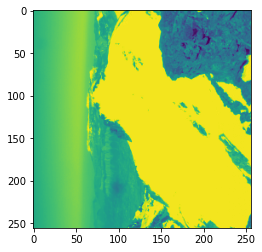

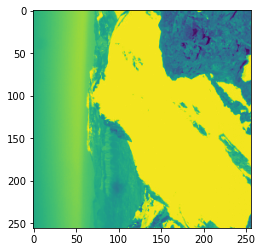

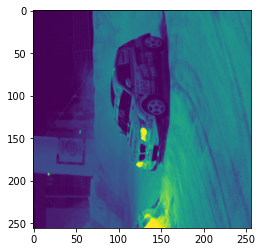

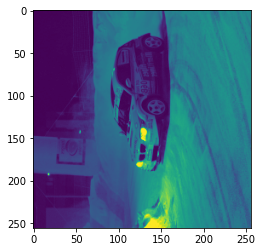

In [80]:
batch = train_generator[0]

first_images = batch[0][0:4]

for np_image in first_images:
    plt.imshow(np_image, )
    plt.show()

# model


## blocks

In [89]:
class Type1(keras.Model):
    def __init__(self,filters,kernel=(3,3),*args,**kwargs):
        super(Type1, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters,
                                           kernel,
                                           padding="same",
                                           kernel_initializer=tf.keras.initializers.HeNormal(),
                                           kernel_regularizer=tf.keras.regularizers.L2(l2=2e-4),
                                           bias_initializer=tf.keras.initializers.Constant(0.2),
                                        )
        self.bn=tf.keras.layers.BatchNormalization(momentum=0.9)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = tf.nn.relu(x)
        return x

    

In [91]:
class Type2(keras.layers.Layer):
    def __init__(self,filters,kernel=(3,3),*args,**kwargs):
        super(Type2, self).__init__()
        self.type1=Type1(filters,kernel)
        self.conv = tf.keras.layers.Conv2D(filters,
                                           kernel,
                                           padding="same",
                                           kernel_initializer=tf.keras.initializers.HeNormal(),
                                           kernel_regularizer=tf.keras.regularizers.L2(l2=2e-4),
                                           bias_initializer=tf.keras.initializers.Constant(0.2),
                                        )
        self.bn=tf.keras.layers.BatchNormalization(momentum=0.9)

    def call(self, inputs):
        x=self.type1(inputs)
        x = self.conv(x)
        x = self.bn(x)
        x = x+inputs
        return x


In [92]:
class Type3(keras.layers.Layer):
    def __init__(self,filters,kernel=(3,3),*args,**kwargs):
        super(Type3, self).__init__()
        self.type1=Type1(filters,kernel)
        self.conv1 = tf.keras.layers.Conv2D(filters,(1,1),strides=2,
                                           padding="same",
                                           kernel_initializer=tf.keras.initializers.HeNormal(),
                                           kernel_regularizer=tf.keras.regularizers.L2(l2=2e-4),
                                           bias_initializer=tf.keras.initializers.Constant(0.2),
                                        )
        self.conv = tf.keras.layers.Conv2D(filters,
                                           kernel,
                                           padding="same",
                                           kernel_initializer=tf.keras.initializers.HeNormal(),
                                           kernel_regularizer=tf.keras.regularizers.L2(l2=2e-4),
                                           bias_initializer=tf.keras.initializers.Constant(0.2),
                                        )
        self.bn=tf.keras.layers.BatchNormalization(momentum=0.9)
    def call(self, inputs):
        x=self.type1(inputs)
        x = self.conv(x)
        x = self.bn(x)
        x = tf.keras.layers.AveragePooling2D(pool_size=kernel, strides=2,padding="same")(x)
        y=self.conv1(inputs)
        y=self.bn(y)
        return x+y

In [93]:
class Type4(keras.layers.Layer):
    def __init__(self,filters,kernel=(3,3),*args,**kwargs):
        super(Type4, self).__init__()
        self.type1=Type1(filters,kernel)
        self.conv = tf.keras.layers.Conv2D(filters,
                                           kernel,
                                           padding="same",
                                           kernel_initializer=tf.keras.initializers.HeNormal(),
                                           kernel_regularizer=tf.keras.regularizers.L2(l2=2e-4),
                                           bias_initializer=tf.keras.initializers.Constant(0.2),
                                        )
        self.bn=tf.keras.layers.BatchNormalization(momentum=0.9)
    def call(self, inputs):
        x=self.type1(inputs)
        x = self.conv(x)
        x = self.bn(x)
        print(x.shape)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        return x

In [94]:
kernel=(3,3)
inputs = keras.Input(shape=( 256, 256,1), )
x=Type1(64,)(inputs)
x=Type1(16,)(x)

x=Type2(16,)(x)
x=Type2(16,)(x)
x=Type2(16,)(x)
x=Type2(16,)(x)
x=Type2(16,)(x)

x=Type3(16,)(x)
x=Type3(64,)(x)
x=Type3(128,)(x)
x=Type3(256,)(x)
x=Type4(512,)(x)

outputs=tf.keras.layers.Dense(1,
                              activation='sigmoid',
                             kernel_initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=.01))(x)

model = keras.Model(inputs=inputs, outputs=outputs)



(None, 16, 16, 512)


In [95]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 type1_4 (Type1)             (None, 256, 256, 64)      896       
                                                                 
 type1_5 (Type1)             (None, 256, 256, 16)      9296      
                                                                 
 type2 (Type2)               (None, 256, 256, 16)      4768      
                                                                 
 type2_1 (Type2)             (None, 256, 256, 16)      4768      
                                                                 
 type2_2 (Type2)             (None, 256, 256, 16)      4768      
                                                                 
 type2_3 (Type2)             (None, 256, 256, 16)      4768  

In [ ]:

model.compile(optimizer='adamax',#initial learning rate is 0.001
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'],
            )

# Training

## Calbacks

In [ ]:
import numpy as np 
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        try:
          del logs["lr"]
        except:
          pass 
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        try:
          del logs["lr"]
        except:
          pass
          # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [ ]:
checkpoints_path=r""
def lr_schedule(epoch):
    if epoch <= (300-45):
        return 0.001
    else:
        return 0.0001

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
model_checkpoint_callback =tf.keras.callbacks.ModelCheckpoint(os.path.join(checkpoints_path,r"C:\Users\Home\Downloads\Downloads\srnet\checkpoint_pgm",
                                                              monitor="loss",
                                                              verbose=1,
                                                              save_freq='epoch',
                                                              save_weights_only=False, )

class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if not bool(epoch%5):  # or save after some epoch, each k-th epoch etc.
            self.model.save(os.path.join(checkpoints_path,"model_{}.hd5".format(epoch)))
model_checkpoint_callback=CustomSaver()      
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(checkpoints_path, 'training_pgm_log.csv'), append=True, separator=';')


## Fitting

In [ ]:
if True:
    epoch=97
    model=tf.keras.models.load_model(os.path.join(checkpoints_path,"model_{}.hd5".format(epoch)))
    print(model.evaluate(train_generator,verbose=1))

In [ ]:
epochs=457
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[csv_logger, lr_scheduler_callback,model_checkpoint_callback,PlotLearning()],)